ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **14Sep21**

# 04. Legendre Basis Functions Least-Squares Residual
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Gmtrx}{\boldsymbol{\mathsf{G}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Legendre Basis Functions](#legendre)
* [Basis Functions Evaluation Matrix](#eval-matrix)
* [Collocation Approximation](#coll)
  + [Collocation Points](#coll-pts)
  + [Collocation Matrix](#coll-matrix)
  + [Optimal Combination Coefficients](#coll-optimal-coeff)
  + [Best Approximant Function](#coll-approximant)
  + [Results](#coll-res)
  + [Errors](#coll-error)
  + [Residual](#coll-residual)
* [Continuous Approximation ($m\rightarrow\infty$)](#cont)
  + [Gram Matrix](#gram-matrix)
  + [Load Vector](#load-vector)
  + [Optimal Combination Coefficients](#cont-optimal-coeff)
  + [Best Approximant Function](#cont-approximant)
  + [Results](#cont-res)
  + [Errors](#cont-error)
  + [Residual](#cont-residual)
  + [Comparison to Collocation Method](#cont-comparison)
* [Constrained Continuous Approximation ($m\rightarrow\infty$)](#ctr_cont)
  + [Gram Matrix](#ctr_gram-matrix)
  + [Load Vector](#ctr_load-vector)
  + [Optimal Combination Coefficients](#ctr_cont-optimal-coeff)
  + [Best Approximant Function](#ctr_cont-approximant)
  + [Results](#ctr_cont-res)
  + [Errors](#ctr_cont-error)
  + [Residual](#ctr_cont-residual)
  + [Comparison to Unconstrained and Collocation Method](#ctr_cont-comparison)
* [Experiment #1](#ex1)
  + [Collocation Approximation](#ex1_coll)
  + [Continuous Approximation ($m\rightarrow\infty$)](#ex1_cont)
  + [Constrained Continuous Approximation ($m\rightarrow\infty$)](#ex1_ctr_cont)
---

## [Objectives](#toc)<a id="obj"></a>

 + Practical use of Lagrange polynomial basis functions to approximate a given function via the Galerkin Linear Least-Squares method.
 + Review [Introduction Notebook 01](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/01-introduction.ipynb)

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$, compute an approximant $g:[a,b]\rightarrow\Reals$.

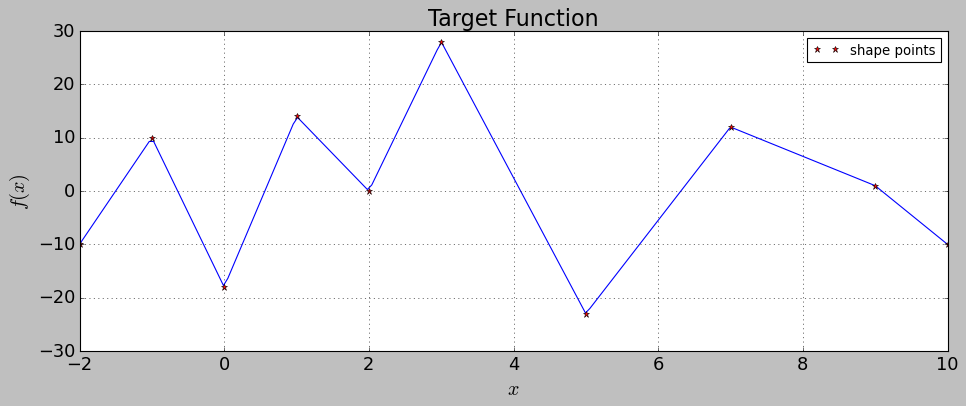

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10),(-1,10),(0,-18),(1,14),(2,0),(3,28),(5,-23),(7,12),(9,1),(10,-10)]

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

## [Legendre Polynomial Basis Functions](#toc)<a id="legendre"></a>

Using Legendre polynomials, $L_k:[-1,1]\rightarrow\Reals$, basis functions

\begin{equation*}
   V := \{L_k \, \mid \, k=0,\ldots,N\} ,
\end{equation*}

where $N$ is the degree of the basis, and the collocation points $\tilde{\xvec}$, compute the best approximant function of $f:\Reals\rightarrow \Reals$ by minimizing the residual vector on the collocation points.

There are multiple ways to generate Lagrange polynomials, here is the most practical:

\begin{align*}
 L_0(\hat{x}) &= 1, \\
 L_1(\hat{x}) &= x, \\
 L_k(\hat{x}) &= \frac{2k-1}{k}\,\hat{x}\,L_{k-1}(\hat{x}) - \frac{k-1}{k}\,L_{k-2}(\hat{x}), \quad \forall \quad k=2,\ldots,N ,
\end{align*}

where the domain of the polynomial functions can be mapped to by $\hat{x}(x) = 2\,\frac{x - (b+a)/2}{b-a}$, when the interval of approximation of the target function is $[a,b] \in \Reals$.

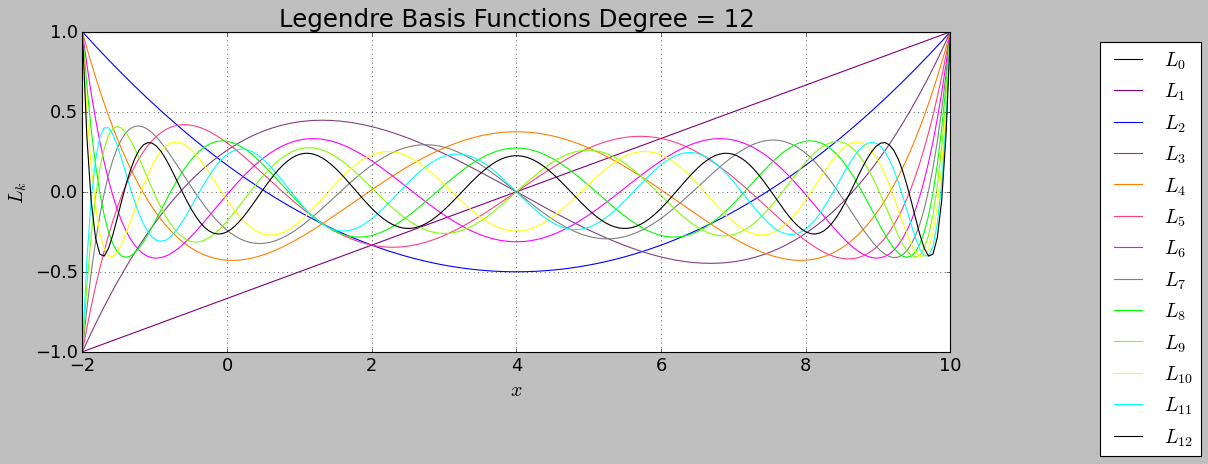

In [2]:
'''Build the basis functions list'''

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

try:    
    from engy_5310.toolkit import LegendreBasis
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
degree = 12

lb = LegendreBasis(degree, x_min, x_max)
lb.plot()

## [Basis Functions Evaluation Matrix](#toc)<a id="eval-matrix"></a>

Build the *basis functions evaluation matrix* $\Amtrx(\xvec)$ as a $m\times n$ real matrix, that is:

$\overset{(m \times n)}{\Amtrx(\xvec)} =  \begin{pmatrix}
1 & L_1(\hat{x}_1) & L_2(\hat{x}_1)  & \ldots & L_N(\hat{x}_1)  \\
1 & L_1(\hat{x}_2) & L_2(\hat{x}_2)  & \ldots & L_N(\hat{x}_2)  \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & L_1(\hat{x}_m) & L_2(\hat{x}_m)  & \ldots & L_N(\hat{x}_m)  \\
 \end{pmatrix}$,
 
and evaluate on the collocation points to create the *basis functions collocation matrix* $\tilde{\Amtrx} = \Amtrx(\tilde{\xvec})$.

## [Collocation Approximation](#toc)<a id="coll"></a>

### [Collocation Points](#toc)<a id="coll-pts"></a>

Select *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$.

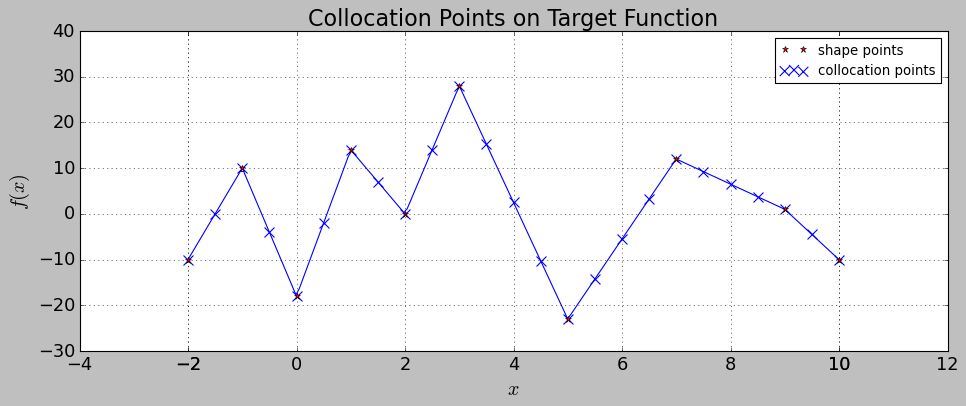

In [3]:
'''Collocation abscissa points'''

import numpy as np

m = 25

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function')

### [Basis Functions Collocation Matrix](#toc)<a id="coll-matrix"></a>

Create the *basis functions collocation matrix* by evaluating the basis function evaluation matrix on the collocation points $\tilde{\Amtrx} = \Amtrx(\tilde{\xvec})$.

In [4]:
'''Build the basis functions collocation matrix'''

a_tilde_mtrx = lb.evaluation_matrix(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')
    
try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is overdetermined.
A is full rank.


In [5]:
'''Build target function vector at the collocation points'''

f_tilde_vec = f(x_tilde_pts)

### [Optimal Combination Coefficients](#toc)<a id="coll-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values (this is not a sufficient condition but a good start). Otherwise the least-squares method for rank-deficient problem must be employed and the shortest, minimal residual 2-norm computed. Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient vector is denoted $\tilde{\cvec}^*$.

In addition to $\tilde{\cvec}^*$, compute the residual 2-norm

\begin{equation*}
 \norm{\tilde{\rvec}(\tilde{\cvec}^*)}_2 =  \norm{\tilde{\fvec} - \tilde{\Amtrx}\,\tilde{\cvec}^*}_2 ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [6]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    #c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
print('')
print('c_tilde_star_vec:\n', c_tilde_star_vec)

print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank; solve for least squares.

c_tilde_star_vec:
 [  1.1  -1.1  -5.4   3.2  -7.6 -19.5  -3.1  23.9  -7.6 -12.4  -5.8   6.3  18.5]

||r^*||_2 =  2.476e+01


### [Best Approximant Function](#toc)<a id="coll-approximant"></a>

The best approximant non-linear function $g^*:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec^*(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\cdot)$ is the Fourier basis functions evaluation matrix on any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec^*(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [7]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = lb.evaluation_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

### [Results](#toc)<a id="coll-res"></a>

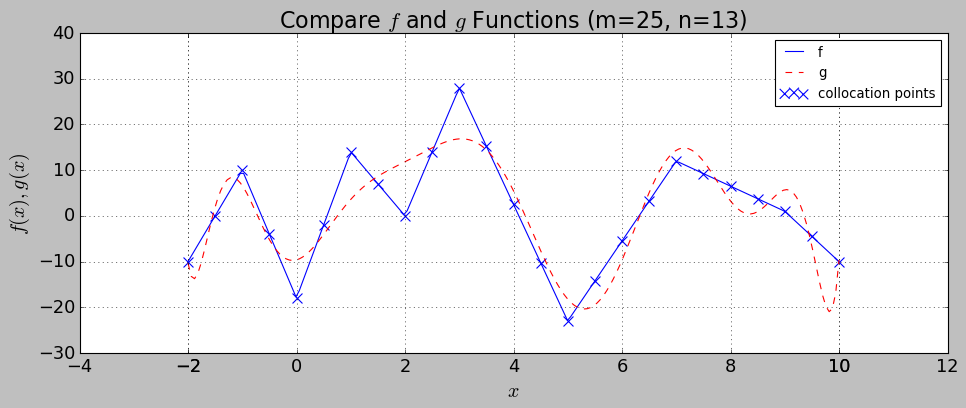

In [8]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ Functions (m='+str(m)+', n='+str(len(lb.basis_func_list))+')')

### [Errors](#toc)<a id="coll-error"></a>

Errors are instrumental to judge how good an approximation is. However the is no one absolute strategy to judge the quality of an approximation. Here we list a few possibilities.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}

In [9]:
'''Relative L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm)

x_ave = (x_min + x_max)/2
x_length = x_max - x_min

def g2_integrand(x):
    x_hat = 2*(x-x_ave)/x_length
    # single value call must be between -1 and 1
    g_vec = g_best_vec_func(np.array([x_hat]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)

print('||g||_L2 =', math.sqrt(g2_integral))
print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    x_hat = 2*(x-x_ave)/x_length
    # single value call must be between -1 and 1
    g_vec = g_best_vec_func(np.array([x_hat]))
    f_x = f(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = (37.09896674212549, 1.5280369562257568e-12)

||g||_L2 = 21.12115654487337
quadrature error = 4.952741037212406e-12

||f-g||_L2 = 46.59968008900003
quadrature error = 3.5414768717600964e-07

Relative error [%] = 125.60910499991522


### [Residual](#toc)<a id="coll-residual"></a>

**The residual vector also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  12
Negatives at collocation pts =  13
Positives =  170
Negatives =  180


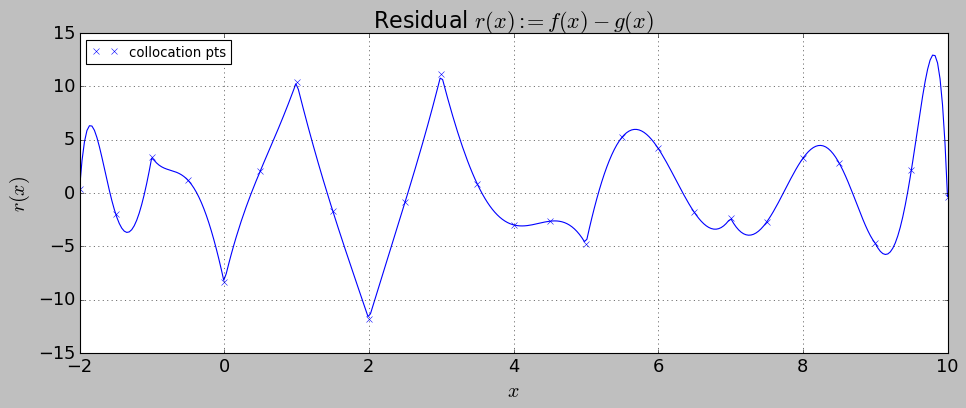

In [10]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline

n_pts = max(3*m, 350)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'bx',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="cont"></a>

### [Gram Matrix](#toc)<a id="gram-matrix"></a>

Build the matrix of inner products of the basis functions, the *Gram matrix* or also called the *mass matrix*: ${(\Gmtrx)}_{i,j} = (\phi_i, \phi_j)$.

In [11]:
'''Build the Gram matrix'''

gram_mtrx = lb.gram_matrix()

#np.set_printoptions(precision=1, threshold=100, edgeitems=5, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


### [Load Vector](#toc)<a id="load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i)$ by computing the inner product of $f$ with each basis function member.

In [12]:
'''Build load vector'''

b_vec = np.zeros(len(lb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(lb.basis_func_list):
    (b_vec[i], _) = lb.inner_product(f, phi_i)                 

### [Optimal Combination Coefficients](#toc)<a id="cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In addition to $\cvec^*$, compute the residual $L^2(a,b)$ norm

\begin{equation*}
 \norm{r(\cvec^*)}_{L^2(a,b)} = \norm{f - g(\cvec^*)}_{L^2(a,b)} ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [13]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(gram_mtrx, b_vec)

### [Best Approximant Function](#toc)<a id="cont-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\cvec^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$.

In [14]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = lb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

### [Results](#toc)<a id="cont-res"></a>

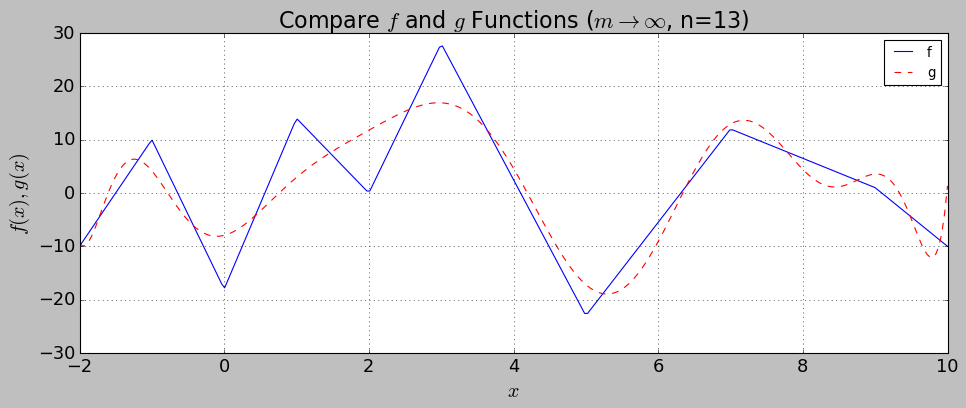

In [15]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')')

### [Errors](#toc)<a id="cont-error"></a>

Errors are measured using functional norms.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [16]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 34.03307356026562

||f-g||_L2 = 14.767641564409615

Relative error [%] = 39.80607240913023


### [Residual](#toc)<a id="cont-residual"></a>

**The residual function also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives =  141
Negatives =  159


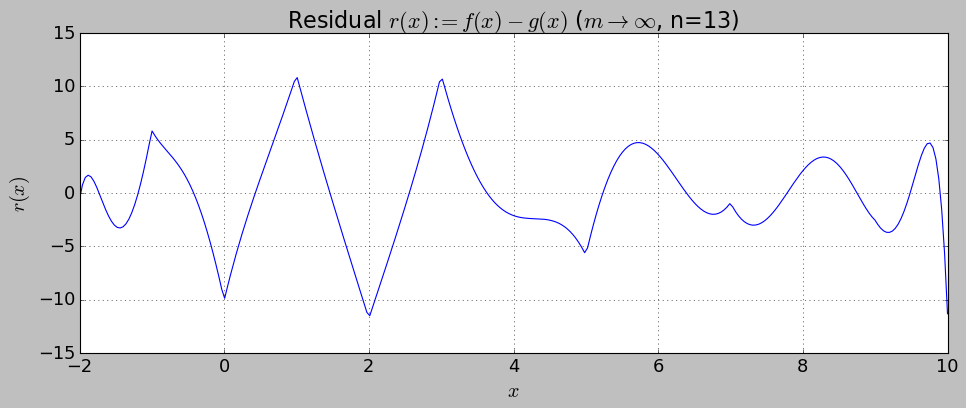

In [17]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)

print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### [Comparison to Collocation Method](#toc)<a id="cont-comparison"></a>

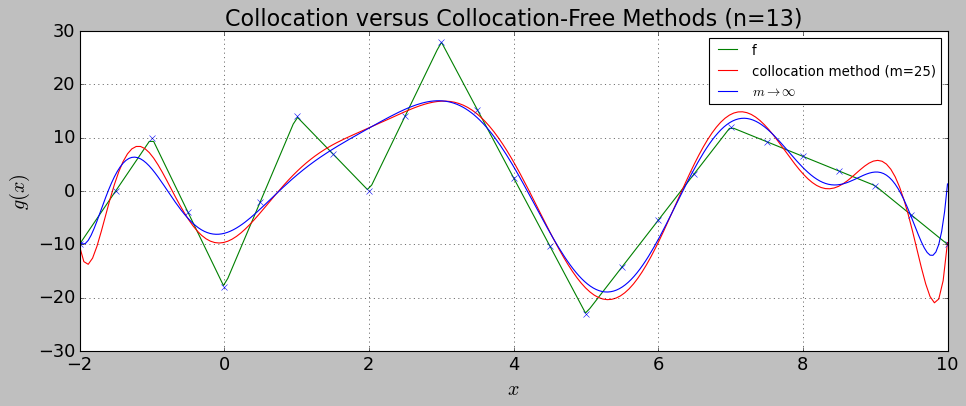

In [18]:
'''Code for comparison to collocation method'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

plt.plot(x_tilde_pts, f(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** The end points of the approximation in the continuous case ($m\rightarrow \infty$) are not as well approximated compared to the collocation method. This is because the continuous case leaves the end points unconstrained.

## [Contrained Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ctr_cont"></a>

In [19]:
'''Build the Gram matrix'''

gram_mtrx = lb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


### [Load Vector](#toc)<a id="ctr_load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i) + f(a)\phi_i(a) + f(b)\phi_i(b)$ by computing the inner product of $f$ with each basis function member.

In [20]:
'''Build load vector'''

b_vec = np.zeros(len(lb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(lb.basis_func_list):
    (b_vec[i], _) = lb.inner_product(f, phi_i) \
                  + f(x_min)*phi_i(x_min) + f(x_max)*phi_i(x_max)               

### [Optimal Combination Coefficients](#toc)<a id="ctr_cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In addition to $\cvec^*$, compute the residual $L^2(a,b)$ norm

\begin{equation*}
 \norm{r(\cvec^*)}_{L^2(a,b)} = \norm{f - g(\cvec^*)}_{L^2(a,b)} ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [21]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(gram_mtrx, b_vec)

### [Best Approximant Function](#toc)<a id="ctr_cont-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\cvec^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$.ipynb_checkpoints/

In [22]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = lb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

### [Results](#toc)<a id="ctr_cont-res"></a>

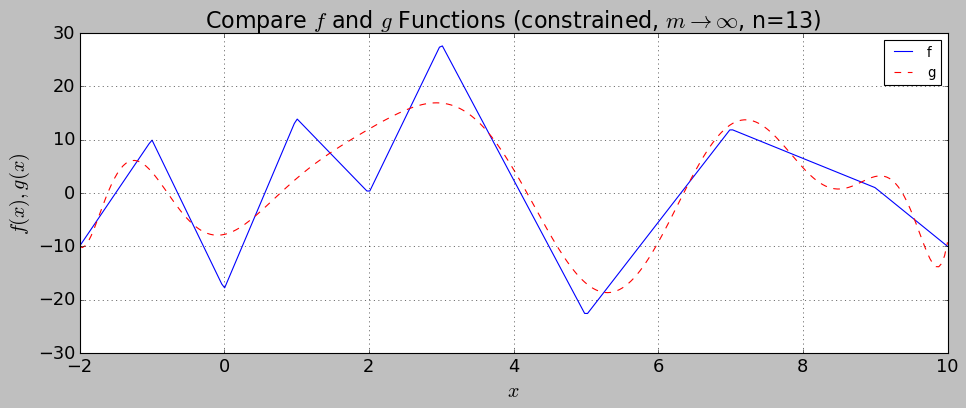

In [23]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_3 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_3), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions (constrained, $m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')')

### [Errors](#toc)<a id="ctr_cont-error"></a>

Errors are measured using functional norms.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [24]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 34.116683768576046

||f-g||_L2 = 15.033943315019362

Relative error [%] = 40.523886876742786


### [Residual](#toc)<a id="ctr_cont-residual"></a>

**The residual function also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives =  120
Negatives =  130


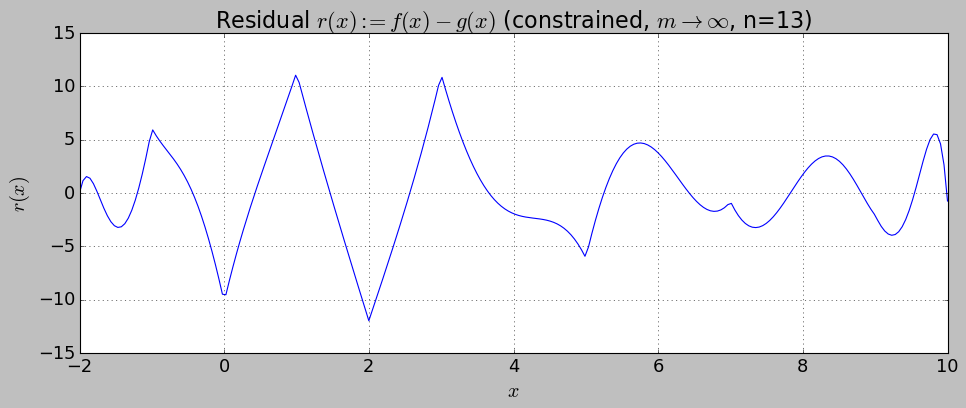

In [25]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (constrained, $m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### [Comparison to Unconstrained and Collocation Method](#toc)<a id="ctr_cont-comparison"></a>

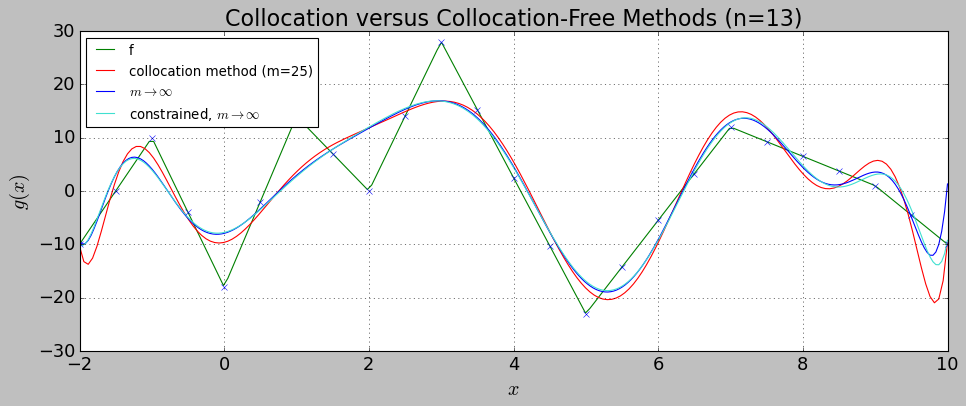

In [26]:
'''Code for comparison to collocation and unconstrainted methods'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_3))
plt.plot(x_pts, g_best_vec_3, '-', color='turquoise', label=r'constrained, $m\rightarrow \infty$')

#plt.plot([p[0] for p in shape_pts], [p[1] for p in shape_pts],'r*')
plt.plot(x_tilde_pts, f(x_tilde_pts), 'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** Constrained and unconstrained continuous least-squares give similar approximation in the interior of the domain. On the end points, the constrained method is the best at being the closest to the ordinate values.

## [Experiment #1](#toc)<a id="ex1"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:(a,b)\in\Reals\rightarrow \Reals$.

# shape pts =  10


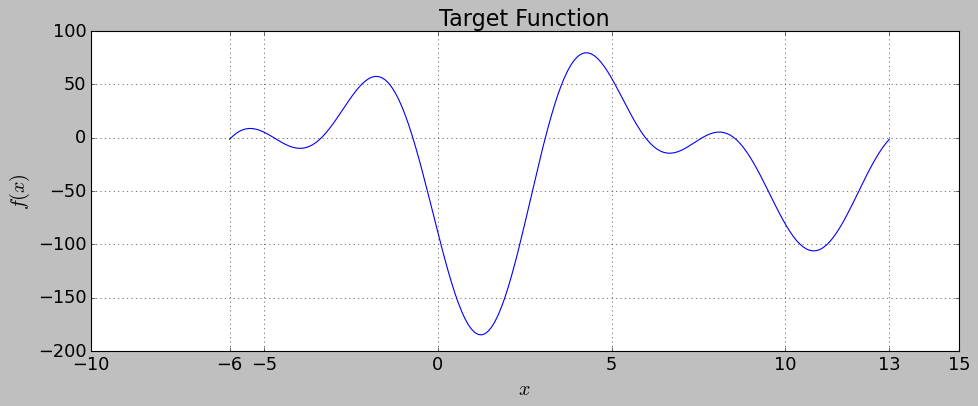

In [27]:
'''Consider another function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-6,-2), (-5,5), (-4,-10), (-3,14), (-1,26), (3,-12), (6, -1), (7, -12), (8,5), (13,-1)]
print('# shape pts = ', len(shape_pts))

f = TargetFunction(shape_pts, type='fourier')
  
f.plot(n_plot_pts=200, title='Target Function')

### [Collocation Approximation](#toc)<a id="ex1_coll"></a>

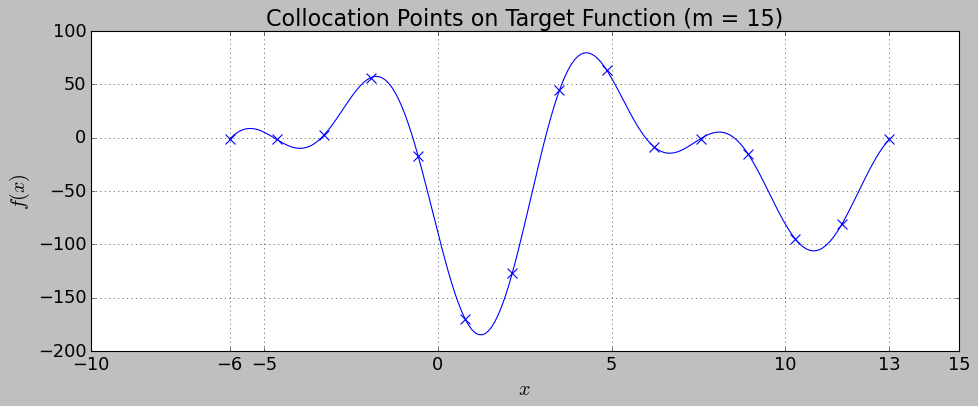

In [28]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 15

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, title='Collocation Points on Target Function (m = '+str(m)+')')

In [29]:
'''Build the basis functions'''

try:    
    from engy_5310.toolkit import LegendreBasis
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
degree = 8

lb = LegendreBasis(degree, x_min, x_max)

In [30]:
'''Build the basis function collocation matrix and target function vector at the collocation points'''

a_tilde_mtrx = lb.evaluation_matrix(x_tilde_pts)
f_tilde_vec = f(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')
    
try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is overdetermined.
A is full rank.


In [31]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
print('')
print('c_tilde_star_vec:\n', c_tilde_star_vec)

print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank; solve for least squares.

c_tilde_star_vec:
 [-28.3 -17.5 -14.3 -36.1 -20.4 141.    6.8 -90.   56.9]

||r^*||_2 =  1.438e+02


In [32]:
'''Build the best approximant function'''

def g_best_vec_func(x):
    a_mtrx = lb.evaluation_matrix(x)
    return a_mtrx@c_tilde_star_vec

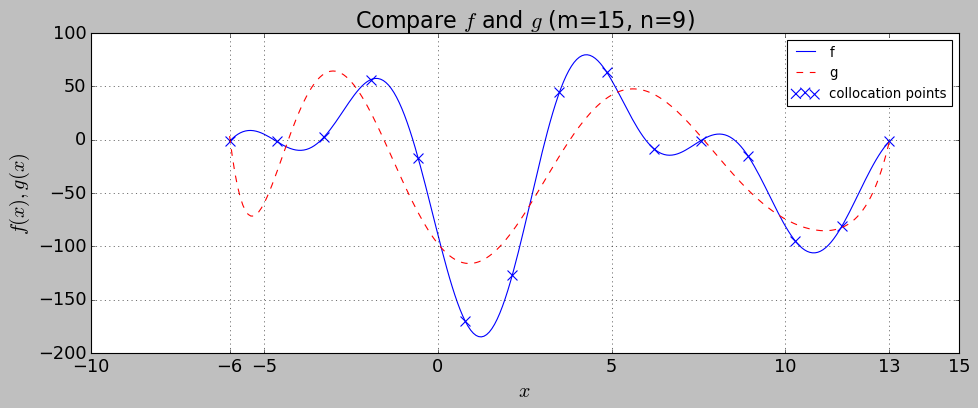

In [33]:
'''Plot comparison of f and g_vec'''

n_pts = max(2*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ (m='+str(m)+', n='+str(len(lb.basis_func_list))+')')

In [34]:
'''Relative L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)

print('||g||_L2 =', math.sqrt(g2_integral))
print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = (308.86050663149206, 7.691031498779921e-06)

||g||_L2 = 265.71085377504676
quadrature error = 7.838425221547349e-10

||f-g||_L2 = 178.91325420906776
quadrature error = 1.2974882679372968e-05

Relative error [%] = 57.92687972973278


Positives at collocation pts =  8
Negatives at collocation pts =  7
Positives =  160
Negatives =  140


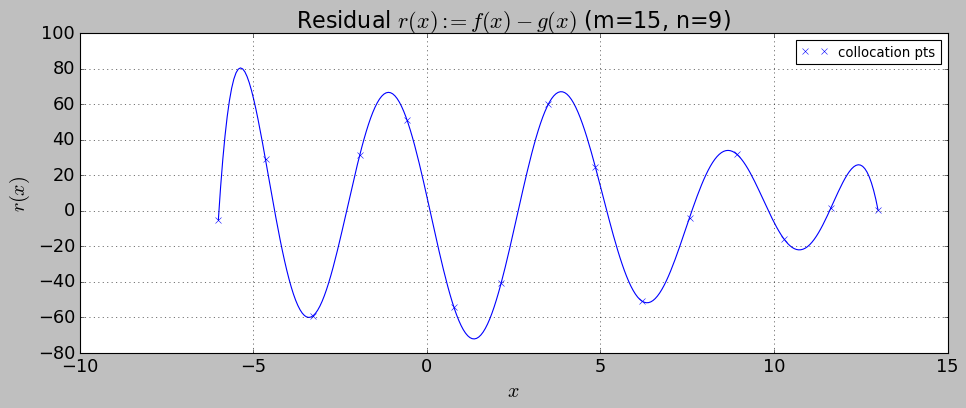

In [35]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline

n_pts = max(4 * m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'bx',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (m='+str(m)+', n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ex1_cont"></a>

In [36]:
'''Build the Gram matrix'''

gram_mtrx = lb.gram_matrix()

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [37]:
'''Build load vector'''

b_vec = np.zeros(len(lb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(lb.basis_func_list):
    (b_vec[i], _) = lb.inner_product(f, phi_i)                 

In [38]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

In [39]:
'''Build the best approximant function'''

def g_best_vec_func(x):
    a_mtrx = lb.evaluation_matrix(x)
    return a_mtrx@c_star_vec

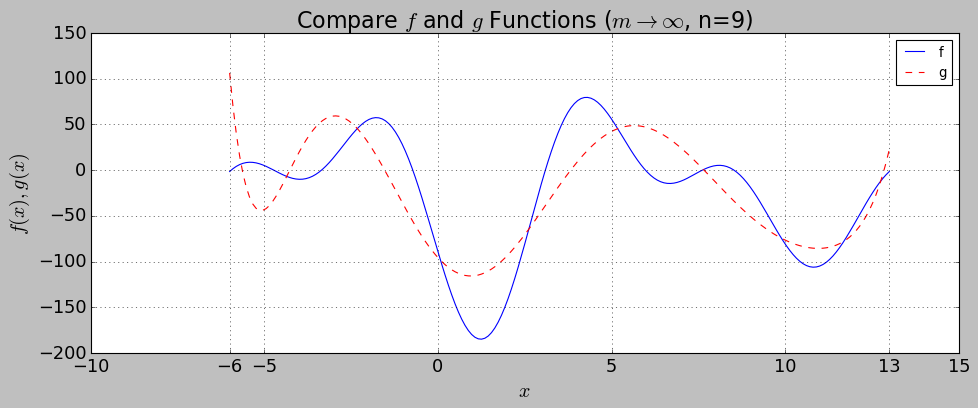

In [40]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')')

In [41]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 308.86050663149206

||g||_L2 = 258.87589184360166

||f-g||_L2 = 168.4579626460021

Relative error [%] = 54.54176206703981


Positives =  126
Negatives =  124


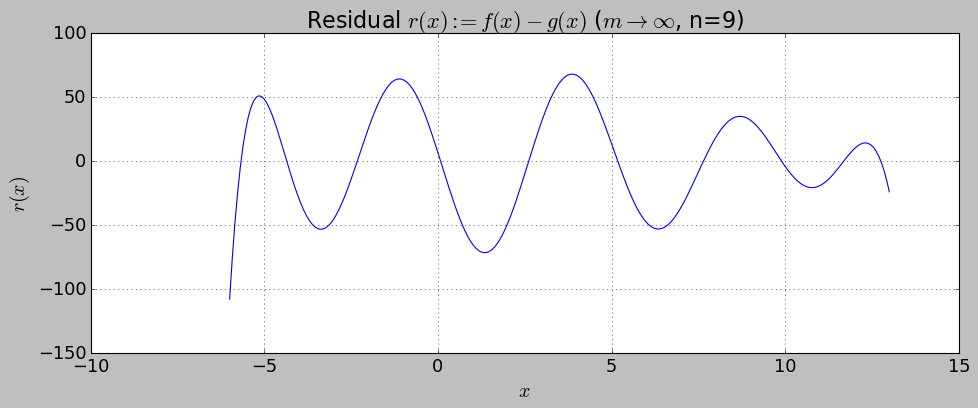

In [42]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

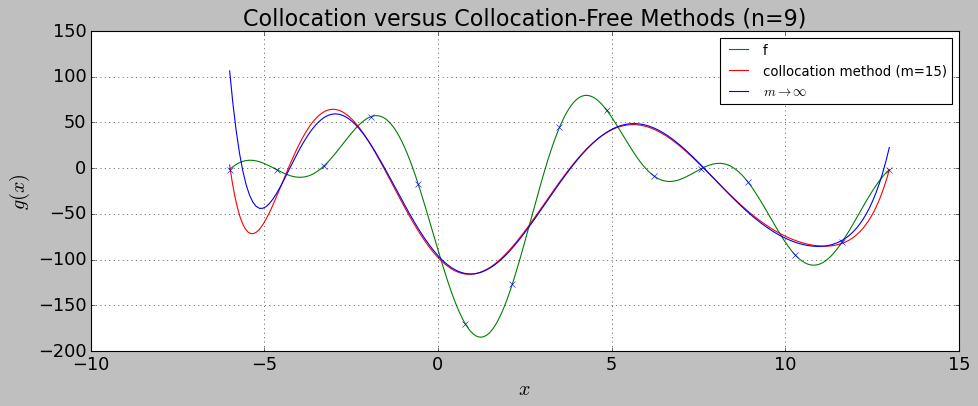

In [43]:
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

plt.plot(x_tilde_pts, f(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Contrained Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ex1_ctr_cont"></a>

In [44]:
'''Build the Gram matrix'''

gram_mtrx = lb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [45]:
'''Build load vector'''

b_vec = np.zeros(len(lb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(lb.basis_func_list):
    (b_vec[i], _) = lb.inner_product(f, phi_i)                 

In [46]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

In [47]:
'''Build the best approximant function'''

def g_best_vec_func(x):
    a_mtrx = lb.evaluation_matrix(x)
    return a_mtrx@c_star_vec

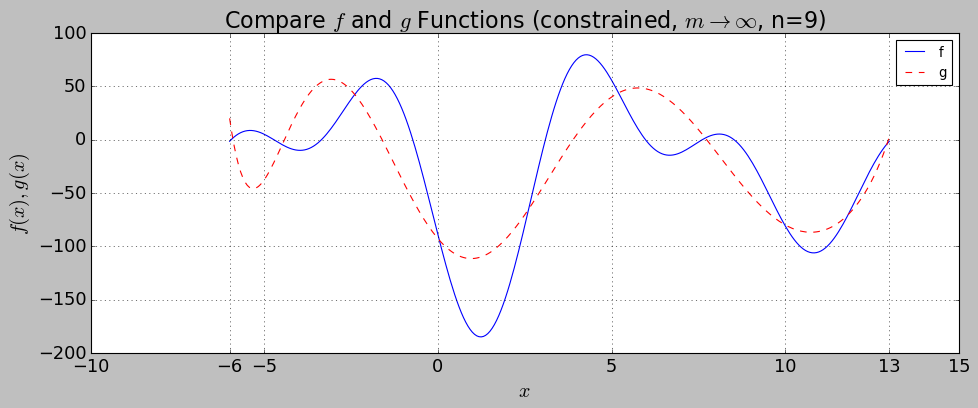

In [48]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_3 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_3), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions (constrained, $m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')')

In [49]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 308.86050663149206

||g||_L2 = 253.82976154812937

||f-g||_L2 = 173.64955558199526

Relative error [%] = 56.22264804129852


Positives =  129
Negatives =  121


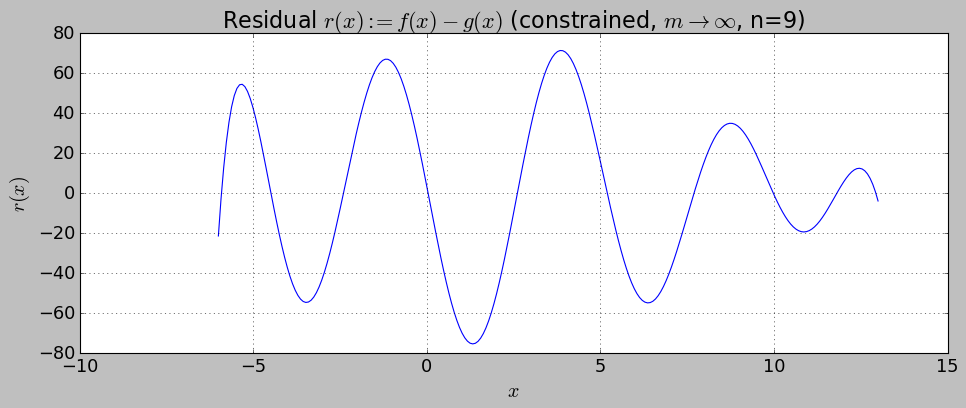

In [50]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (constrained, $m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

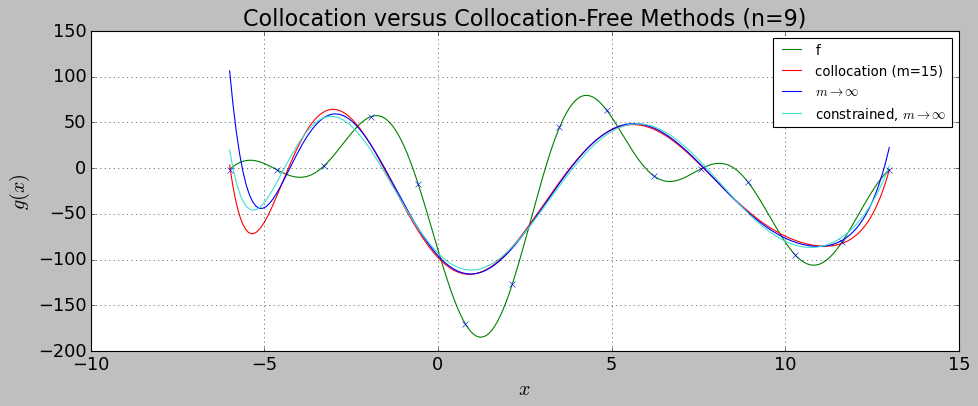

In [51]:
'''Code for comparison to unconstrained and collocation methods'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_3))
plt.plot(x_pts, g_best_vec_3, '-', color='turquoise', label=r'constrained, $m\rightarrow \infty$')

plt.plot(x_tilde_pts, f(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(lb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** Here the end points are better approximated by the constrained method but the overall approximation has higher error because the interior approximation is adversely affected.